    Age Primary streaming service  Hours per day While working  \
0  18.0                   Spotify            4.0            No   
1  61.0             YouTube Music            2.5           Yes   
2  18.0                   Spotify            4.0           Yes   
3  18.0                   Spotify            5.0           Yes   
4  18.0             YouTube Music            3.0           Yes   

  Instrumentalist Composer         Fav genre Exploratory Foreign languages  \
0              No       No  Video game music          No               Yes   
1              No      Yes              Jazz         Yes               Yes   
2              No       No               R&B         Yes                No   
3             Yes      Yes              Jazz         Yes               Yes   
4             Yes       No  Video game music         Yes               Yes   

     BPM  ...  K pop_frequency  Latin_frequency  Lofi_frequency  \
0  132.0  ...                3                0               2   


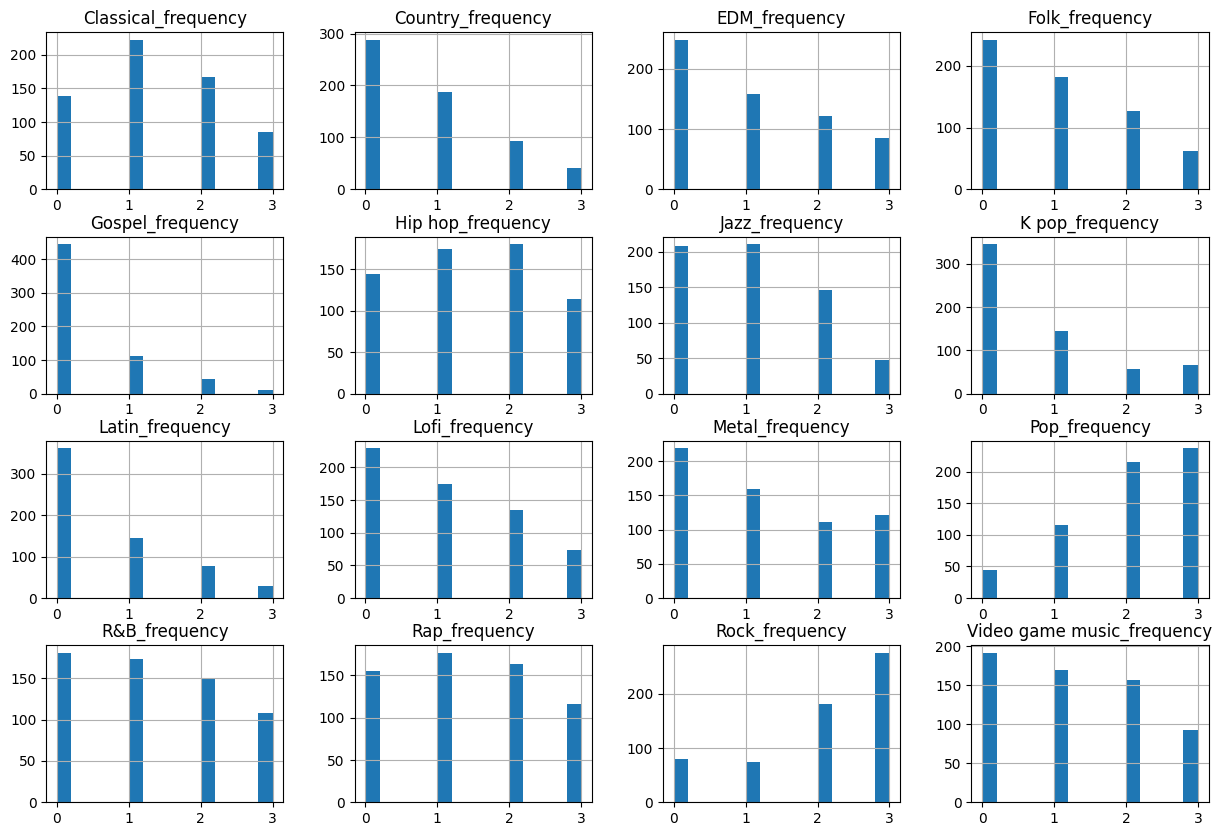

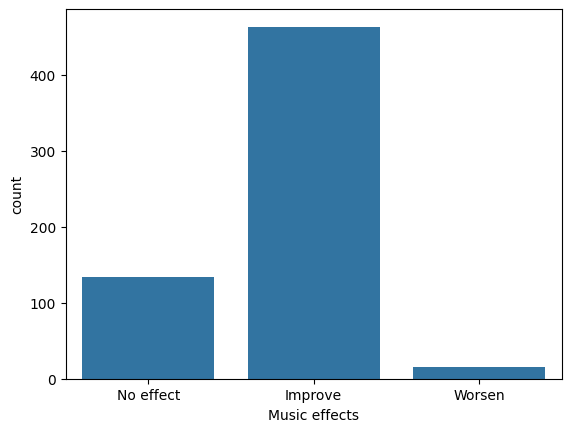

Melhores parâmetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Acurácia: 0.35714285714285715
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.33      0.50      0.40         4
           2       0.38      0.60      0.46         5

    accuracy                           0.36        14
   macro avg       0.24      0.37      0.29        14
weighted avg       0.23      0.36      0.28        14



c:\Users\tulio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tulio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tulio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

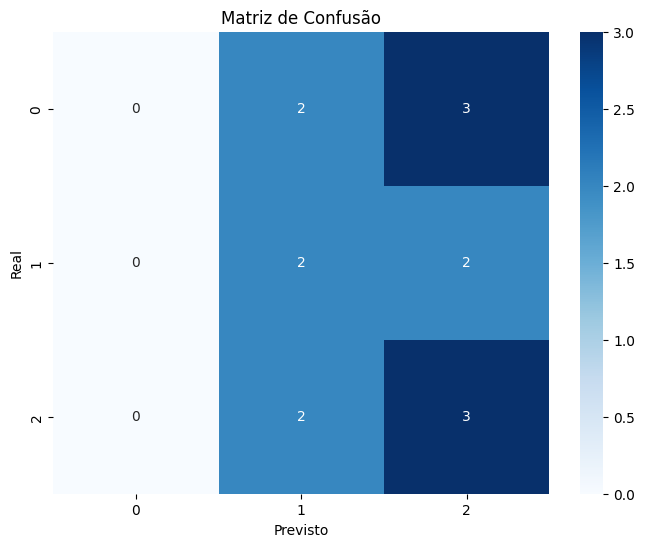

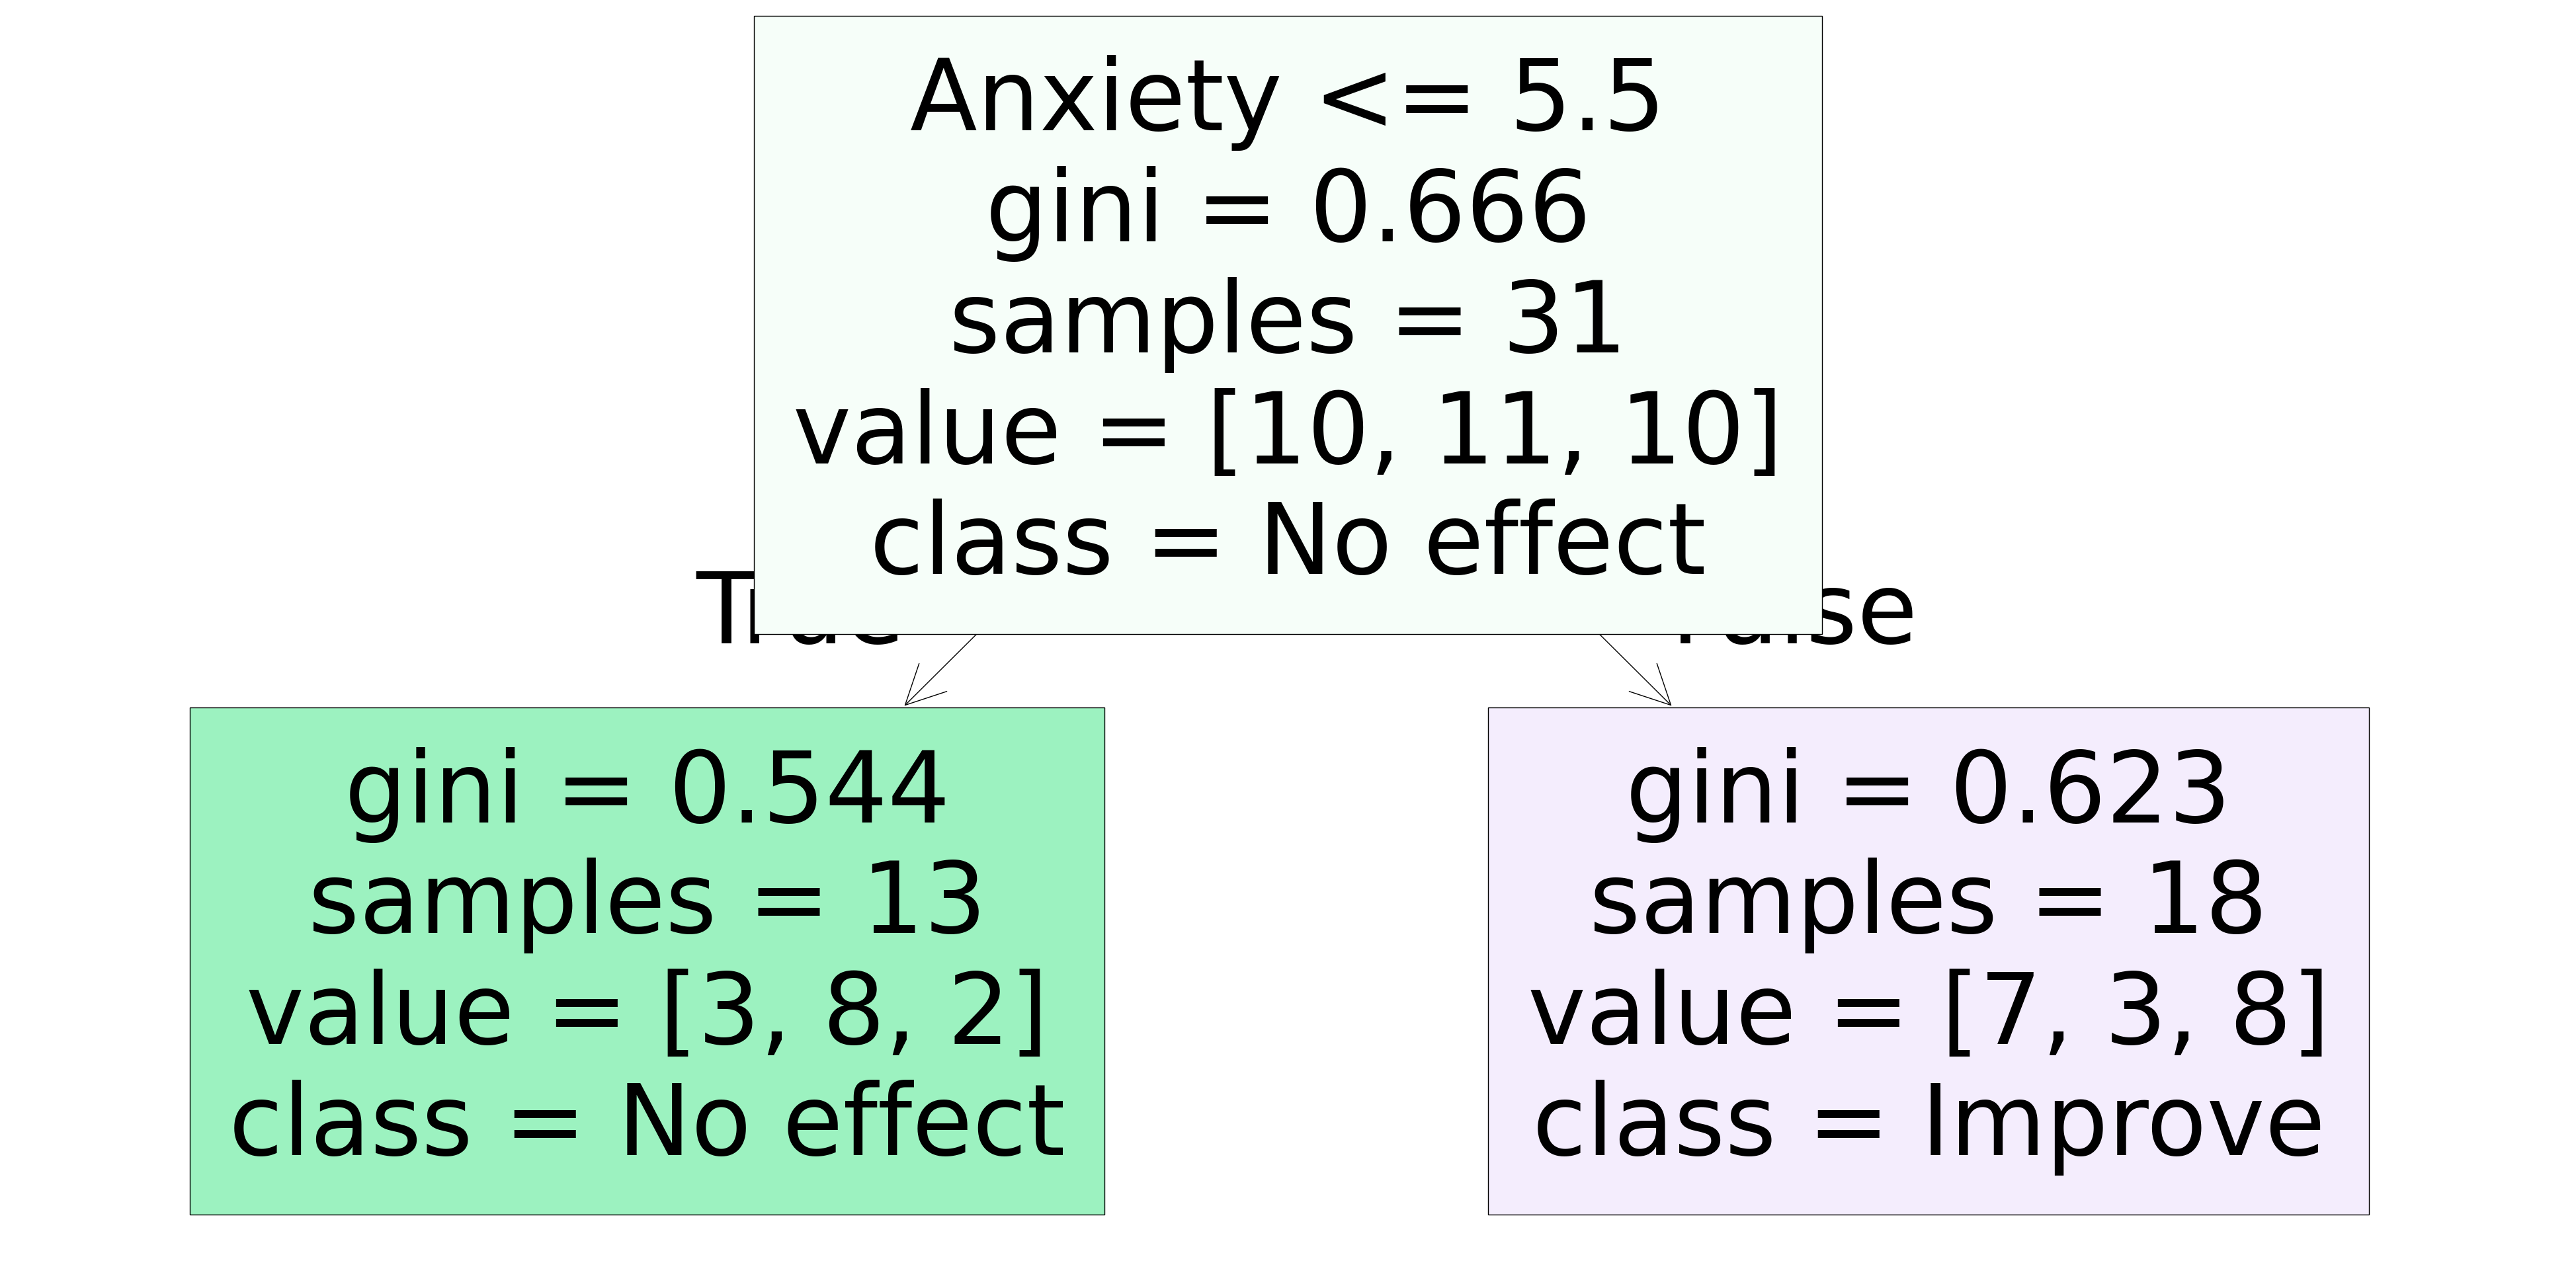

In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler  # Undersampling

# Carregando dataset
file_path = 'data/dados_tratados_V2.csv'
data = pd.read_csv(file_path, delimiter=';')

# Informações iniciais
print(data.head())
print(data.info())

# Visualização da distribuição das frequências dos estilos musicais
style_columns = [col for col in data.columns if 'frequency' in col]
data[style_columns].hist(bins=15, figsize=(15, 10))
plt.show()

# Relação entre frequência de gêneros musicais e "Music effects"
sns.countplot(x='Music effects', data=data)
plt.show()

data_clean = data.dropna(subset=['Music effects'])

data_clean['Music effects'] = data_clean['Music effects'].map({'Worsen': 0, 'No effect': 1, 'Improve': 2})


# Define X e y
X = data_clean[style_columns + ['Anxiety', 'Depression', 'Insomnia', 'OCD', 'Age']]
y = data_clean['Music effects']

# Aplicar undersampling com RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Definir treinamento e teste do modelo
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Definição de hiperparâmetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Treinamento do modelo
model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Parâmetros melhor avaliados
best_model = grid_search.best_estimator_
print("Melhores parâmetros:", grid_search.best_params_)

# Previsões
y_pred = best_model.predict(X_test)

# Métricas
y_pred = best_model.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title("Matriz de Confusão")
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

#Árvore de Decisão
plt.figure(figsize=(50, 25))
plot_tree(best_model, feature_names=X.columns, class_names=['Worsen', 'No effect', 'Improve'], filled=True)
plt.show()

classification_rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

precision_per_class = {
    int(cls): metrics['precision']
    for cls, metrics in classification_rep.items() if cls.isdigit()  # Filtrar apenas classes numéricas
}

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": classification_rep['macro avg']['precision'],  # Média macro
    "precision_per_class": precision_per_class
}

import joblib
joblib.dump(best_model, 'models/decision-tree-classifier-undersampling.pkl')

with open('metrics/decision-tree-classifier-undersampling.json', 'w') as metrics_file:
    json.dump(metrics, metrics_file, indent=4)